In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

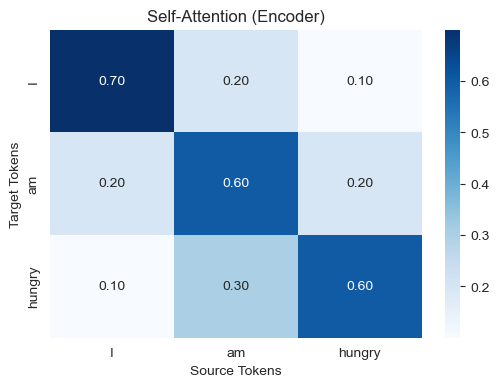

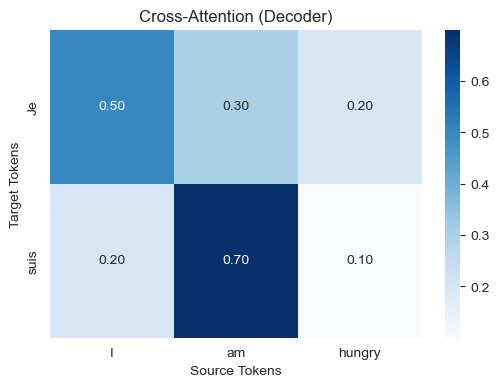

In [2]:
# Dummy data for attention weights
self_attention_weights = torch.tensor([
    [0.7, 0.2, 0.1],
    [0.2, 0.6, 0.2],
    [0.1, 0.3, 0.6]
])

cross_attention_weights = torch.tensor([
    [0.5, 0.3, 0.2],
    [0.2, 0.7, 0.1]
])

# Tokens for source and target sequences
source_tokens = ["I", "am", "hungry"]
target_tokens = ["Je", "suis"]

# Function to plot heatmaps
def plot_attention(weights, x_labels, y_labels, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(weights, annot=True, fmt=".2f", cmap="Blues", xticklabels=x_labels, yticklabels=y_labels)
    plt.title(title)
    plt.xlabel("Source Tokens")
    plt.ylabel("Target Tokens")
    plt.show()

# Plot self-attention heatmap (encoder)
plot_attention(
    self_attention_weights,
    x_labels=source_tokens,
    y_labels=source_tokens,
    title="Self-Attention (Encoder)"
)

# Plot cross-attention heatmap (decoder)
plot_attention(
    cross_attention_weights,
    x_labels=source_tokens,
    y_labels=target_tokens,
    title="Cross-Attention (Decoder)"
)

Epoch 100, Loss: 0.0819


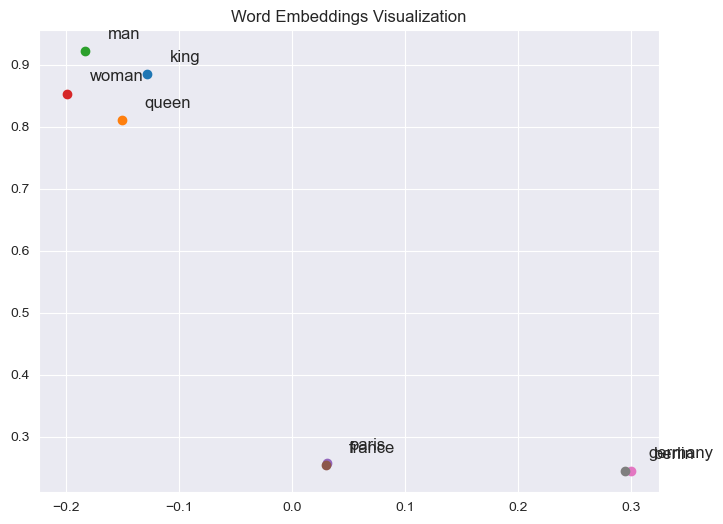

In [3]:
from torch import optim

# Define a simple vocabulary and dataset
vocabulary = ["king", "queen", "man", "woman", "paris", "france", "berlin", "germany"]
word_to_index = {word: idx for idx, word in enumerate(vocabulary)}
index_to_word = {idx: word for word, idx in word_to_index.items()}

# Fake dataset: pairs of related words
pairs = [
    ("king", "queen"),
    ("man", "woman"),
    ("paris", "france"),
    ("berlin", "germany"),
    ("king", "man"),
    ("queen", "woman"),
    ("france", "paris"),
    ("germany", "berlin")
]

# Convert pairs to indices
data = [(word_to_index[w1], word_to_index[w2]) for w1, w2 in pairs]

# Parameters
vocab_size = len(vocabulary)
embedding_dim = 2  # Low dimension for easy visualization
epochs = 150
learning_rate = 0.01

# Define an embedding model
class EmbeddingModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(EmbeddingModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)

    def forward(self, input_word):
        return self.embeddings(input_word)

# Instantiate the model, loss, and optimizer
model = EmbeddingModel(vocab_size, embedding_dim)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)


# Training loop
for epoch in range(epochs):
    total_loss = 0
    for input_idx, target_idx in data:
        input_tensor = torch.tensor([input_idx], dtype=torch.long)
        target_tensor = torch.tensor([target_idx], dtype=torch.long)

        # Forward pass
        input_embedding = model(input_tensor)
        target_embedding = model(target_tensor)

        # Compute loss
        loss = criterion(input_embedding, target_embedding)

        # Backward pass and update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch + 1}, Loss: {total_loss:.4f}")

# Extract embeddings for visualization
embeddings = model.embeddings.weight.detach().numpy()

# Visualize embeddings using t-SNE
def plot_embeddings(embeddings, labels):
    plt.figure(figsize=(8, 6))
    for i, label in enumerate(labels):
        x, y = embeddings[i]
        plt.scatter(x, y, marker='o')
        plt.text(x + 0.02, y + 0.02, label, fontsize=12)
    plt.title("Word Embeddings Visualization")
    plt.show()

plot_embeddings(embeddings, vocabulary)

In [4]:
import bitsandbytes as bnb

# Use 8-bit AdamW optimizer to reduce memory usage
optimizer = bnb.optim.AdamW8bit(model.parameters(), lr=3e-4)

In [4]:
print("CUDA Available:", torch.cuda.is_available())
print("CUDA Version:", torch.version.cuda)
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU Found")

print(torch.__version__)
print(torch.version.cuda)

CUDA Available: True
CUDA Version: 12.6
GPU Name: NVIDIA GeForce RTX 3050 Ti Laptop GPU
2.7.0.dev20250122+cu126
12.6


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tensor = torch.randn(3, 3).to(device)

print(f"✅ Tensor successfully moved to: {tensor.device}")
print(tensor)

✅ Tensor successfully moved to: cuda:0
tensor([[-0.2878,  1.2998, -0.3121],
        [ 0.6537, -0.1038,  0.9566],
        [ 1.8134,  0.0073, -0.0045]], device='cuda:0')


In [6]:
from transformers import GPT2LMHeadModel

model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)
print("✅ Model successfully loaded on:", next(model.parameters()).device)

✅ Model successfully loaded on: cuda:0


In [2]:
from datasets import load_dataset

wiki = load_dataset("wikipedia", "20220301.en", split="train", trust_remote_code=True)
wiki = wiki.shuffle(seed=42).select(range(100_000))  # Reduce size

dataset = wiki

Loading dataset shards:   0%|          | 0/41 [00:00<?, ?it/s]

In [3]:
dataset = dataset.remove_columns([col for col in dataset.column_names if col != "text"])
print(dataset[0])  # Now only contains raw text
#dataset.save_to_disk("small_wiki_dataset")

{'text': "William Edward Whitehouse (20 May 1859 – 12 January 1935) was an English cellist.\n\nCareer\nHe studied for one year with Alfredo Piatti, for whom he deputised (taking his place in concerts when called upon), and was his favourite pupil. He went on to teach at the Royal Academy of Music, Royal College of Music and King's College, Cambridge; his students included Felix Salmond and Beatrice Harrison, who both became closely associated with Edward Elgar. He played with violinist Joseph Joachim, and formed The London Trio with violinist Achille Simonetti and pianist Amina Goodwin. He edited Piatti's Caprices, with suggestions as to how his former teacher preferred them to be played.\n\nExternal links\n William Whitehouse\n The Violoncello and the Romantic Era: 1820-1920: Part II — A Survey of Current Cello Teachers on Romantic Repertoire and Aesthetics\n\n1859 births\n1935 deaths\n20th-century classical musicians\nAcademics of the Royal Academy of Music\nAcademics of the Royal Co

Saving the dataset (0/1 shards):   0%|          | 0/100000 [00:00<?, ? examples/s]

In [4]:
from transformers import AutoTokenizer

# Load a pre-trained GPT-2 tokenizer (or any other you prefer)
tokenizer = AutoTokenizer.from_pretrained("gpt2")

tokenizer.pad_token = tokenizer.eos_token  # This will prevent padding errors

# Print tokenizer details
print("Tokenizer vocab size:", tokenizer.vocab_size)
print("Example tokenized text:", tokenizer("Hello, how are you?"))

Tokenizer vocab size: 50257
Example tokenized text: {'input_ids': [15496, 11, 703, 389, 345, 30], 'attention_mask': [1, 1, 1, 1, 1, 1]}


In [29]:
train_dataset = dataset["train"]
eval_dataset = dataset["test"]

In [30]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # GPT-2 doesn't have a native pad token

def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=512
    )

# Tokenize train set (remove original "text" column)
tokenized_train = train_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=["text"]
)

# Tokenize eval set (remove original "text" column)
tokenized_eval = eval_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=["text"]
)

print(tokenized_train[0])  # Should have "input_ids" and "attention_mask"
print(tokenized_eval[0])


Map:   0%|          | 0/90000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

{'input_ids': [464, 2705, 26667, 357, 273, 220, 26667, 11, 1267, 318, 530, 286, 262, 3210, 42563, 319, 257, 19132, 11, 4143, 4624, 1364, 1712, 1871, 262, 42563, 13, 1550, 257, 4490, 19132, 428, 26667, 15381, 262, 2187, 2223, 357, 8201, 262, 10586, 8, 4622, 284, 262, 826, 11, 523, 326, 262, 25755, 364, 543, 7685, 5587, 477, 1115, 286, 262, 13042, 329, 257, 3465, 5587, 691, 734, 286, 606, 13, 770, 2705, 641, 262, 3465, 290, 635, 953, 6945, 663, 8216, 3081, 13, 45362, 3081, 318, 635, 5676, 416, 10833, 262, 5637, 734, 13042, 852, 7425, 284, 787, 2800, 351, 257, 636, 286, 262, 15554, 2936, 543, 318, 407, 1690, 2277, 357, 23301, 284, 262, 2187, 2223, 852, 14869, 1776, 428, 2482, 287, 257, 19222, 263, 2128, 11, 355, 6886, 284, 262, 6016, 2128, 543, 318, 3221, 4635, 357, 23301, 284, 262, 2936, 852, 33034, 422, 3218, 779, 737, 198, 198, 18122, 198, 198, 464, 6393, 2163, 286, 262, 2705, 26667, 373, 15646, 416, 13167, 349, 462, 78, 24568, 78, 1640, 72, 11, 262, 33475, 286, 262, 19132, 13, 1550, 6

In [33]:
# save them
# Save tokenized train dataset
tokenized_train.save_to_disk("my_tokenized_wiki_train")

# Save tokenized eval dataset
tokenized_eval.save_to_disk("my_tokenized_wiki_eval")

Saving the dataset (0/1 shards):   0%|          | 0/90000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10000 [00:00<?, ? examples/s]

In [19]:
from transformers import GPT2LMHeadModel, AutoTokenizer

# Load GPT-2 model
model = GPT2LMHeadModel.from_pretrained("gpt2")

# Load tokenizer and add padding token
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # Set EOS as padding token

# Resize model embeddings (if new tokens were added)
model.resize_token_embeddings(len(tokenizer))

Embedding(50257, 768)

In [24]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./gpt2-wiki-finetuned",
    evaluation_strategy="steps",  # Evaluate periodically
    eval_steps=1000,              # Evaluate every 1000 steps
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=8,
    num_train_epochs=3,
    learning_rate=5e-5,
    warmup_steps=1000,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=500,
    save_strategy="steps",
    save_steps=1000,
    fp16=True,
    push_to_hub=False,
)

In [10]:
from transformers import DataCollatorForLanguageModeling

# Create a data collator that handles padding & causal masking
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False  # MLM=False because GPT-2 is autoregressive (not masked language modeling)
)

In [ ]:
from transformers import GPT2LMHeadModel, Trainer

model = GPT2LMHeadModel.from_pretrained("gpt2")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,        # Train set
    eval_dataset=tokenized_eval,          # Validation set
    data_collator=data_collator,
    tokenizer=tokenizer
)

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

In [34]:
trainer.train() # may god help us

RuntimeError: cannot reshape tensor of 0 elements into shape [-1, 0] because the unspecified dimension size -1 can be any value and is ambiguous